# Home Loan Approval Predict and Visualize Importance

In [24]:
import os
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import sys  #this willl help to exit()
import missingno as msno # Our hero ^_^

### Data Prep

In [2]:
train0 = pd.read_csv('loan_sanction_test.csv')
display(train0)
print(train0.columns.tolist())
test0 = pd.read_csv("loan_sanction_train.csv")
data0=pd.concat([train0,test0],axis=0)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban
...,...,...,...,...,...,...,...,...,...,...,...,...
362,LP002971,Male,Yes,3+,Not Graduate,Yes,4009,1777,113.0,360.0,1.0,Urban
363,LP002975,Male,Yes,0,Graduate,No,4158,709,115.0,360.0,1.0,Urban
364,LP002980,Male,No,0,Graduate,No,3250,1993,126.0,360.0,NaN,Semiurban
365,LP002986,Male,Yes,0,Graduate,No,5000,2393,158.0,360.0,1.0,Rural


['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area']


In [3]:
train0.shape

(367, 12)

In [4]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            367 non-null    object 
 1   Gender             356 non-null    object 
 2   Married            367 non-null    object 
 3   Dependents         357 non-null    object 
 4   Education          367 non-null    object 
 5   Self_Employed      344 non-null    object 
 6   ApplicantIncome    367 non-null    int64  
 7   CoapplicantIncome  367 non-null    int64  
 8   LoanAmount         362 non-null    float64
 9   Loan_Amount_Term   361 non-null    float64
 10  Credit_History     338 non-null    float64
 11  Property_Area      367 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 34.5+ KB


In [5]:
train0.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,367.000000,367.000000,362.000000,361.000000,338.000000
mean,4805.599455,1569.577657,136.132597,342.537396,0.825444
std,4910.685399,2334.232099,61.366652,65.156643,0.380150
min,0.000000,0.000000,28.000000,6.000000,0.000000
25%,2864.000000,0.000000,100.250000,360.000000,1.000000
50%,3786.000000,1025.000000,125.000000,360.000000,1.000000
75%,5060.000000,2430.500000,158.000000,360.000000,1.000000
max,72529.000000,24000.000000,550.000000,480.000000,1.000000


In [6]:
train0.isnull().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [7]:
trainc = train0['Gender'].value_counts()
trainc

Male      286
Female     70
Name: Gender, dtype: int64

In [8]:
train0['Gender'].unique()

array(['Male', 'Female', nan], dtype=object)

In [9]:
print('Depend column has null value around:.',train0['Dependents'].isnull().sum())


Depend column has null value around:. 10


In [10]:
train0['Dependents'].unique()

array(['0', '1', '2', '3+', nan], dtype=object)

In [11]:
# here from dependent column removed 3+ to 3
def depend(value):
    if(value == '3+'):
        return '3'
    else:
        return value


# depend(train0['Dependents'])
train0['Dependents']=train0['Dependents'].apply(depend)
print('Replace "3+" to "3"')
train0['Dependents'].unique()

Replace "3+" to "3"


array(['0', '1', '2', '3', nan], dtype=object)

In [12]:
train0['Dependents'] = train0['Dependents'].astype('Int64')

# How to handle missing values in gender column
###  Based on the problem at hand, we can try to do one of the following:

As you mentioned, mode is one of the option which can be used
Missing values can be treated as a separate category by itself. We can create another category for the missing values and use them as a different level.





<ol start="1">
  <li>If the number of missing values are lesser compared to the number of samples and also the total number of samples is high, we can also choose to remove those rows in our analysis</li>
  <li>We can also try to do an imputation based on the values of other variables in the given dataset. We can identify related rows to the given row and then use them for imputation</li>
    <li>We can also run a model to predict the missing values using all other variables as inputs.
Depending on the nature of the problem and the dataset, we could choose to use the one that seems more suitable.</li>
</ol>

In [13]:
train0['Gender'].isnull().sum()

11

In [14]:
train0[train0['Gender'].isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
22,LP001128,NaN,No,0,Graduate,No,3909,0,101.0,360.0,1.0,Urban
51,LP001287,NaN,Yes,3,Not Graduate,No,3500,833,120.0,360.0,1.0,Semiurban
106,LP001563,NaN,No,0,Graduate,No,1596,1760,119.0,360.0,0.0,Urban
138,LP001769,NaN,No,<NA>,Graduate,No,3333,1250,110.0,360.0,1.0,Semiurban
209,LP002165,NaN,No,1,Not Graduate,No,2038,4027,100.0,360.0,1.0,Rural
231,LP002298,NaN,No,0,Graduate,Yes,2860,2988,138.0,360.0,1.0,Urban
245,LP002355,NaN,Yes,0,Graduate,No,3186,3145,150.0,180.0,0.0,Semiurban
279,LP002553,NaN,No,0,Graduate,No,29167,0,185.0,360.0,1.0,Semiurban
296,LP002614,NaN,No,0,Graduate,No,6478,0,108.0,360.0,1.0,Semiurban
303,LP002657,NaN,Yes,1,Not Graduate,Yes,570,2125,68.0,360.0,1.0,Rural


In [15]:
train0['Gender'].fillna(train0['Gender'].mode()[0], inplace=True)
# here fill nan with mode value

In [16]:
train0['Gender'].value_counts()

Male      297
Female     70
Name: Gender, dtype: int64

In [17]:
train0.Dependents.value_counts()

0    200
2     59
1     58
3     40
Name: Dependents, dtype: Int64

In [18]:
# mean
mean = train0.Dependents.mean()
print(mean)
print('----------')

median = train0.Dependents.median()
print(median)

print('----------')

mode = train0.Dependents.mode()
print(mode)

0.8291316526610645
----------
0.0
----------
0    0
Name: Dependents, dtype: Int64


In [19]:
train0.Dependents.fillna(0, inplace=True)

In [20]:
train0.Dependents.value_counts()

0    210
2     59
1     58
3     40
Name: Dependents, dtype: Int64

In [21]:
train0.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [22]:
train0[train0.Self_Employed.isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
8,LP001059,Male,Yes,2,Graduate,NaN,13633,0,280.0,240.0,1.0,Urban
11,LP001082,Male,Yes,1,Graduate,NaN,2185,1516,162.0,360.0,1.0,Semiurban
13,LP001094,Male,Yes,2,Graduate,NaN,12173,0,166.0,360.0,0.0,Semiurban
36,LP001208,Male,Yes,2,Graduate,NaN,7350,4029,185.0,180.0,1.0,Urban
72,LP001375,Male,Yes,1,Graduate,NaN,4083,1775,139.0,60.0,1.0,Urban
89,LP001472,Female,No,0,Graduate,NaN,5058,0,200.0,360.0,1.0,Rural
142,LP001789,Male,Yes,3,Not Graduate,NaN,6794,528,139.0,360.0,0.0,Urban
161,LP001906,Male,No,0,Graduate,NaN,2964,0,84.0,360.0,0.0,Semiurban
168,LP001950,Female,Yes,3,Graduate,NaN,1750,2935,94.0,360.0,0.0,Semiurban
175,LP001999,Male,Yes,2,Graduate,NaN,4912,4614,160.0,360.0,1.0,Rural


In [23]:
train0.head(50)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban
5,LP001054,Male,Yes,0,Not Graduate,Yes,2165,3422,152.0,360.0,1.0,Urban
6,LP001055,Female,No,1,Not Graduate,No,2226,0,59.0,360.0,1.0,Semiurban
7,LP001056,Male,Yes,2,Not Graduate,No,3881,0,147.0,360.0,0.0,Rural
8,LP001059,Male,Yes,2,Graduate,NaN,13633,0,280.0,240.0,1.0,Urban
9,LP001067,Male,No,0,Not Graduate,No,2400,2400,123.0,360.0,1.0,Semiurban


<AxesSubplot:>

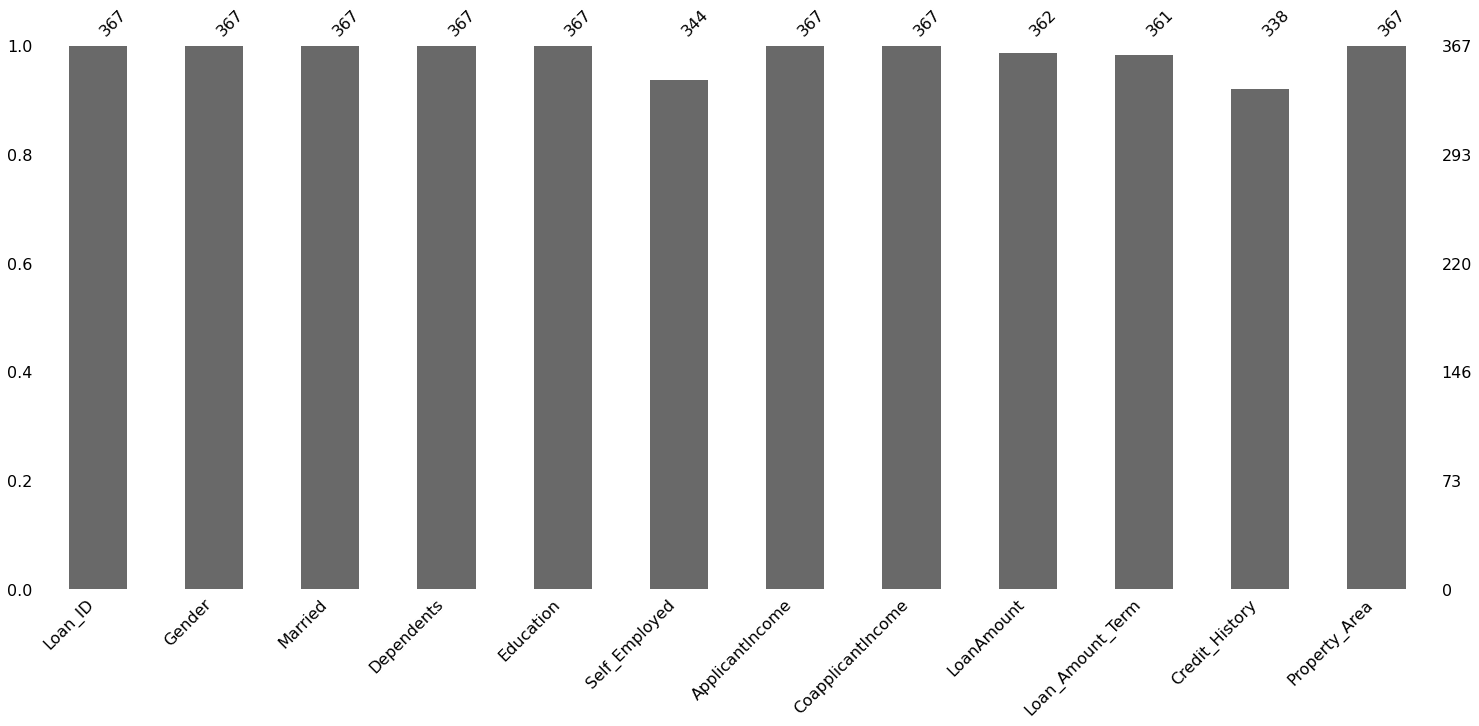

In [25]:
# plotting bargrapgh from missing no libraray

msno.bar(train0)

<AxesSubplot:>

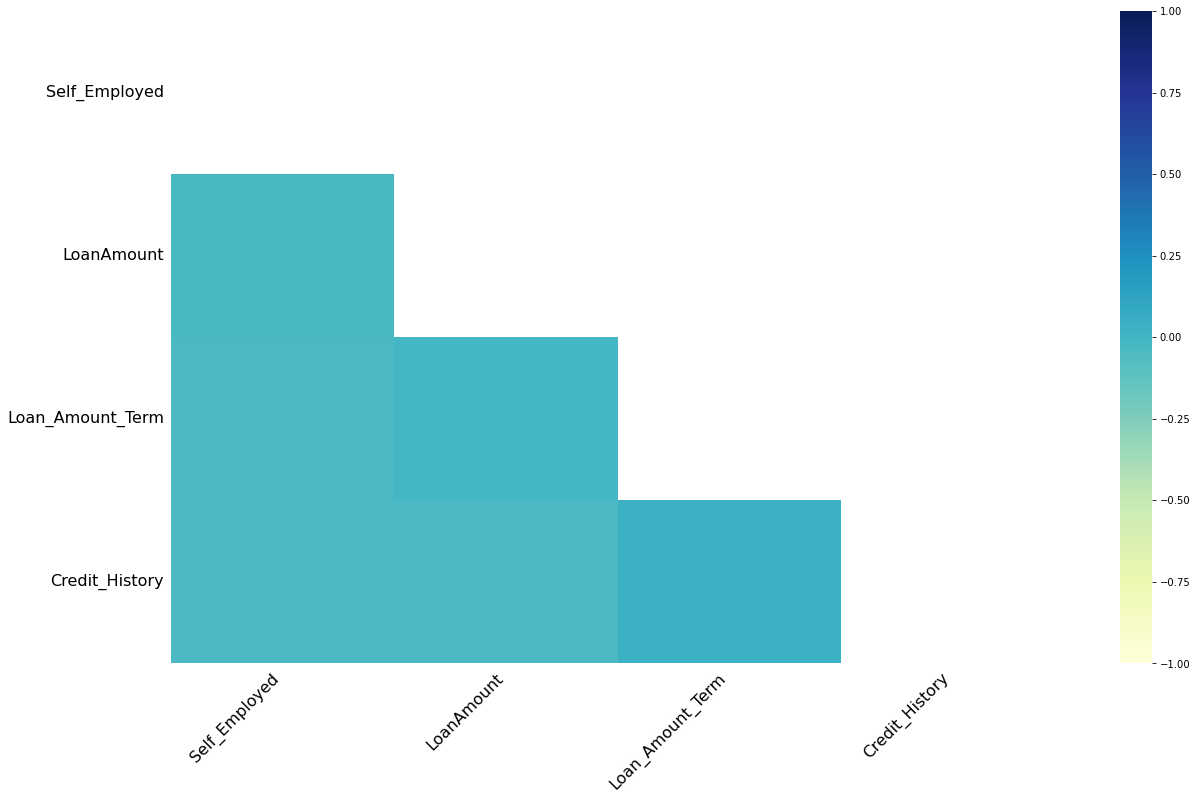

In [26]:
msno.heatmap(train0, cmap='YlGnBu')